In [167]:
#Bibliotecas utiloizadas
import spacy
from spacy.symbols import nsubj, VERB
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pymongo
from pymongo import MongoClient
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import nltk

In [168]:
#listagem das urls
urls = [
    'https://www1.folha.uol.com.br/banco-de-dados/2021/05/1971-dom-paulo-evaristo-arns-sofre-acidente-automobilistico-em-sc.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/02/1971-chuvas-provocam-22-mortes-em-sao-paulo-no-abc-e-na-baixada-santista.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/02/1971-petrobras-intensifica-pesquisas-no-mar-e-contrata-2-navios-sonda.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-apos-soltar-tenente-nixon-estudara-condenacao-por-massacre-de-my-lai.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/02/1971-ingleses-propoem-que-nobel-da-paz-seja-entregue-aos-irmaos-villas-boas.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/02/1971-brasil-lidera-batalha-para-evitar-que-preco-do-cafe-continue-em-queda.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/02/1971-campeonato-nacional-de-futebol-vai-substituir-o-velho-robertao.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/01/1971-estudantes-localizam-o-1o-foco-de-ferrugem-do-cafeeiro-em-sao-paulo.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2021/02/1971-se-o-sistema-falhar-astronautas-podem-fazer-passeio-pelo-espaco.shtml',
    'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-fraude-faz-faculdade-da-santa-casa-de-sao-paulo-anular-o-vestibular.shtml',

]

In [169]:
#puxando os textos das urls e fazendo a tratativa
lista = []

for artigos in urls:
    response = urlopen(artigos)
    html = response.read().decode('utf-8')
    " ".join(html.split()).replace('> <', '><')
    soup = BeautifulSoup(html, 'html.parser')
    titulo = soup.find('h1', {'class':'c-content-head__title'}).get_text()
    titulo = "".join(titulo.strip() for linha in range(len(titulo.split("\n")) -2))
    artigo = soup.find('div', {'class': 'c-news__body'}).get_text()
    artigo = artigo.replace('\n', ' ').replace('\r', '').replace('  ', '').replace('Primeira Página da Folha de', '').replace('- Reprodução', '')
    conteudo = {}
    conteudo[titulo] = artigo
    print(conteudo)

{'1971: Dom Paulo Evaristo Arns sofre acidente automobilístico em SC': ' O arcebispo de São Paulo, dom Paulo Evaristo Arns, teve fratura exposta no tornozelo e escoriações na cabeça, ao sofrer um acidente automobilístico, em Santa Catarina, nesta sexta-feira (14). Segundo os médicos, seu estado de saúde é bom. O carro, que era dirigido pelo irmão marista Antonio Poeing, capotou na rodovia BR-101 após tentar desviar de uma pedra na pista. A mãe de dom Paulo, Helena, e as irmãs dele Zilda e Ida também estavam no automóvel.Eles iam para Forquilhinha, terra natal do arcebispo, para assistir a uma cerimônia religiosa. 15 de maio de 1971 '}


HTTPError: HTTP Error 503: Backend fetch failed

In [87]:
#transformando o texto em json para salvar no mongo
conteudo = {}
conteudo[titulo] = artigo

jsonArray = json.dumps(conteudo, ensure_ascii = False)

In [88]:
#importando os textos para o mongo
import pymongo
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["Textos"]
mycol = mydb["Artigos"]
x = mycol.insert_one(conteudo)

In [89]:
#tratativas com spacy
nlp = spacy.load("pt_core_news_sm")

In [90]:
#puxando o texto 1
texto1 = "1971: Dom Paulo Evaristo Arns sofre acidente automobilístico em SC': ' O arcebispo de São Paulo, dom Paulo Evaristo Arns, teve fratura exposta no tornozelo e escoriações na cabeça, ao sofrer um acidente automobilístico, em Santa Catarina, nesta sexta-feira (14). Segundo os médicos, seu estado de saúde é bom. O carro, que era dirigido pelo irmão marista Antonio Poeing, capotou na rodovia BR-101 após tentar desviar de uma pedra na pista. A mãe de dom Paulo, Helena, e as irmãs dele Zilda e Ida também estavam no automóvel.Eles iam para Forquilhinha, terra natal do arcebispo, para assistir a uma cerimônia religiosa. 15 de maio de 1971"
doc1 = nlp(texto1)

In [91]:
#tokenização do texto 1
tokens = [token for token in doc1]
[(token.orth_, token.pos_) for token in doc1]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Dom', 'PROPN'),
 ('Paulo', 'PROPN'),
 ('Evaristo', 'PROPN'),
 ('Arns', 'PROPN'),
 ('sofre', 'VERB'),
 ('acidente', 'NOUN'),
 ('automobilístico', 'ADJ'),
 ('em', 'ADP'),
 ('SC', 'PROPN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('O', 'DET'),
 ('arcebispo', 'NOUN'),
 ('de', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 (',', 'PUNCT'),
 ('dom', 'NOUN'),
 ('Paulo', 'PROPN'),
 ('Evaristo', 'PROPN'),
 ('Arns', 'PROPN'),
 (',', 'PUNCT'),
 ('teve', 'VERB'),
 ('fratura', 'NOUN'),
 ('exposta', 'VERB'),
 ('no', 'ADP'),
 ('tornozelo', 'NOUN'),
 ('e', 'CCONJ'),
 ('escoriações', 'NOUN'),
 ('na', 'ADP'),
 ('cabeça', 'NOUN'),
 (',', 'PUNCT'),
 ('ao', 'SCONJ'),
 ('sofrer', 'VERB'),
 ('um', 'DET'),
 ('acidente', 'NOUN'),
 ('automobilístico', 'ADJ'),
 (',', 'PUNCT'),
 ('em', 'ADP'),
 ('Santa', 'PROPN'),
 ('Catarina', 'PROPN'),
 (',', 'PUNCT'),
 ('nesta', 'ADP'),
 ('sexta-feira', 'NOUN'),
 ('(', 'PUNCT'),
 ('14', 'NUM'),
 (')', 'PUNCT'),
 ('.', 'PUNCT')

In [92]:
#puxando os verbos do texto 1
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto1)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{iam, teve, capotou}


['sofrer',
 'ter',
 'exposto',
 'sofrer',
 'dirigir',
 'capotar',
 'tentar',
 'desviar',
 'ir',
 'assistir']

In [93]:
#indentificando as entidades do texto 1
for ent in doc1.ents:
    print(ent.text, ent.label_)

Dom Paulo MISC
Evaristo Arns PER
SC LOC
arcebispo de São Paulo LOC
dom Paulo PER
Evaristo Arns PER
Santa Catarina LOC
Antonio Poeing PER
BR-101 LOC
dom Paulo PER
Helena PER
Zilda PER
Ida PER
Forquilhinha LOC


In [94]:
with open("C:/Users/joice/Sprint03/textos/texto1.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

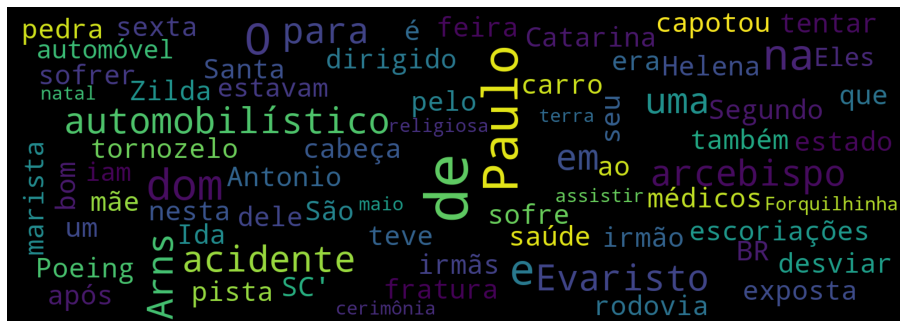

In [95]:
#Nuvem de Palavras texto 1.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [96]:
#puxando o texto 2
texto2 = "1971: Chuvas provocam 22 mortes em São Paulo, no ABC e na Baixada Santista': ' As chuvas que durante dois dias caíram no estado de São Paulo provocaram 22 mortes na capital, na região do ABC e na Baixada Santista. Na cidade de São Paulo, a Companhia de Gás, cuja rede foi intensamente afetada pelas águas, informou que a distribuição de gás deverá ser normalizada até as 12 deste sábado (27). A Companhia Telefônica, porém, só poderá iniciar o conserto de 5.000 telefones emudecidos quando as águas baixarem nas galerias inundadas. A Guanabara também sofreu com as chuvas. Extraoficialmente, já fala-se em 30 mortos. No estado do Rio de Janeiro, o número seria de 50.  27 de fevereiro de 1971 "
doc2 = nlp(texto2)

In [97]:
#tokenização texto 2
tokens = [token for token in doc2]
[(token.orth_, token.pos_) for token in doc2]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Chuvas', 'NOUN'),
 ('provocam', 'VERB'),
 ('22', 'NUM'),
 ('mortes', 'NOUN'),
 ('em', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 (',', 'PUNCT'),
 ('no', 'ADP'),
 ('ABC', 'PROPN'),
 ('e', 'CCONJ'),
 ('na', 'ADP'),
 ('Baixada', 'PROPN'),
 ('Santista', 'PROPN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('As', 'DET'),
 ('chuvas', 'NOUN'),
 ('que', 'PRON'),
 ('durante', 'ADP'),
 ('dois', 'NUM'),
 ('dias', 'NOUN'),
 ('caíram', 'VERB'),
 ('no', 'ADP'),
 ('estado', 'NOUN'),
 ('de', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 ('provocaram', 'VERB'),
 ('22', 'NUM'),
 ('mortes', 'NOUN'),
 ('na', 'ADP'),
 ('capital', 'NOUN'),
 (',', 'PUNCT'),
 ('na', 'ADP'),
 ('região', 'NOUN'),
 ('do', 'ADP'),
 ('ABC', 'PROPN'),
 ('e', 'CCONJ'),
 ('na', 'ADP'),
 ('Baixada', 'PROPN'),
 ('Santista', 'PROPN'),
 ('.', 'PUNCT'),
 ('Na', 'ADP'),
 ('cidade', 'NOUN'),
 ('de', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 (',', 'PUNCT'),
 ('a', 'DET'),
 ('Comp

In [98]:
#puxando os verbos texto2
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto2)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{caíram, provocaram, fala-se, baixarem, iniciar, sofreu, provocam}


['provocar',
 'cair',
 'provocar',
 'afetada',
 'informar',
 'dever',
 'normalizar',
 'poder',
 'iniciar',
 'emudecido',
 'baixar',
 'sofrer',
 'fala-se']

In [99]:
#indentificando as entidades do texto 2
for ent in doc2.ents:
    print(ent.text, ent.label_)

São Paulo LOC
ABC LOC
Baixada Santista LOC
estado de São Paulo LOC
ABC LOC
Baixada Santista LOC
Companhia de Gás ORG
Companhia Telefônica ORG
Guanabara LOC
Rio de Janeiro LOC


In [100]:
with open("C:/Users/joice/Sprint03/textos/texto2.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

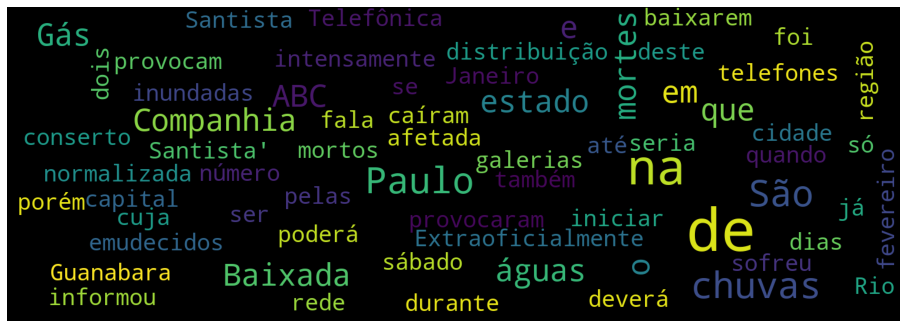

In [101]:
#Nuvem de Palavras texto 2.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [102]:
#puxando o texto 3
texto3 = "1971: Petrobras intensifica pesquisas no mar e contrata 2 navios-sonda': ' A Petrobras contratou dois navios-sonda, um vai operar no litoral norte do Paraná e outro atuará em Sergipe. O consumo brasileiro de petróleo é atualmente de 500 mil barris por dia, dos quais 170 mil são extraídos no país. O restante é importado. Os técnicos aguardam notícias mais concretas sobre a capacidade de produção do campo de Caioba, descoberto a 12 quilômetros de Aracaju (SE) pela plataforma de fabricação nacional “Petrobras-1”. Mas o clima é de euforia com o primeiro poço perfurado.O navio-sonda que agora foi contratado para Sergipe vai operar nos campos de Dourado e de Guaricema.  13 de fevereiro de 1971"
doc3 = nlp(texto3)

In [103]:
#tokenização texto 3
tokens = [token for token in doc3]
[(token.orth_, token.pos_) for token in doc3]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Petrobras', 'NOUN'),
 ('intensifica', 'VERB'),
 ('pesquisas', 'NOUN'),
 ('no', 'ADP'),
 ('mar', 'NOUN'),
 ('e', 'CCONJ'),
 ('contrata', 'VERB'),
 ('2', 'NUM'),
 ('navios-sonda', 'NOUN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('A', 'DET'),
 ('Petrobras', 'PROPN'),
 ('contratou', 'VERB'),
 ('dois', 'NUM'),
 ('navios-sonda', 'NOUN'),
 (',', 'PUNCT'),
 ('um', 'NUM'),
 ('vai', 'AUX'),
 ('operar', 'VERB'),
 ('no', 'ADP'),
 ('litoral', 'NOUN'),
 ('norte', 'ADJ'),
 ('do', 'ADP'),
 ('Paraná', 'PROPN'),
 ('e', 'CCONJ'),
 ('outro', 'DET'),
 ('atuará', 'VERB'),
 ('em', 'ADP'),
 ('Sergipe', 'PROPN'),
 ('.', 'PUNCT'),
 ('O', 'DET'),
 ('consumo', 'NOUN'),
 ('brasileiro', 'ADJ'),
 ('de', 'ADP'),
 ('petróleo', 'NOUN'),
 ('é', 'AUX'),
 ('atualmente', 'ADV'),
 ('de', 'ADP'),
 ('500', 'NUM'),
 ('mil', 'NUM'),
 ('barris', 'NOUN'),
 ('por', 'ADP'),
 ('dia', 'NOUN'),
 (',', 'PUNCT'),
 ('dos', 'ADP'),
 ('quais', 'PRON'),
 ('170', 'NUM'),
 ('mil', 'NUM'),
 ('

In [104]:
#puxando os verbos texto 3
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto3)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{atuará, operar, contratou, aguardam, intensifica}


['intensificar',
 'contratar',
 'contratar',
 'operar',
 'atuará',
 'extrair',
 'importar',
 'aguardar',
 'descobrir',
 'perfurar',
 'contratar',
 'operar']

In [105]:
#indentificando as entidades do texto 3
for ent in doc3.ents:
    print(ent.text, ent.label_)

Petrobras ORG
Petrobras ORG
Paraná LOC
Sergipe LOC
Caioba LOC
Aracaju LOC
Sergipe LOC
Dourado PER
Guaricema PER


In [106]:
with open("C:/Users/joice/Sprint03/textos/texto3.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

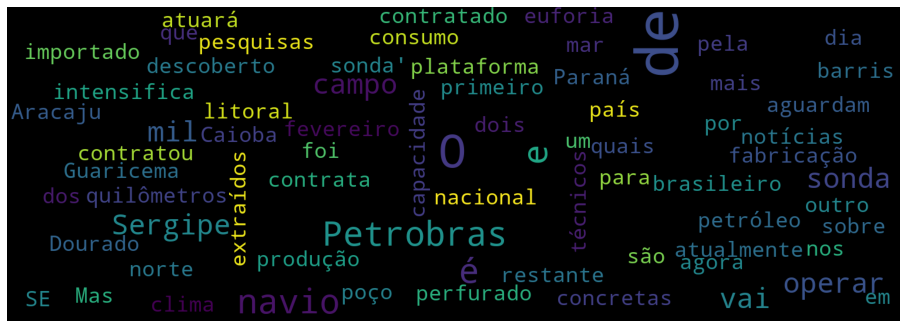

In [107]:
#Nuvem de Palavras texto3.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [108]:
#puxando texto 4
texto4 = "1971: Após soltar tenente, Nixon estudará condenação por massacre de My Lai': ' Depois de ter mandado soltar o tenente William Calley (condenado à prisão perpétua pela Corte Marcial pelo assassinato de 22 civis em My Lai, no Vietnã do Sul), o presidente dos Estados Unidos, Richard Nixon, “revisará pessoalmente o caso”, informou a Casa Branca. Conforme o divulgado, essa revisão será feita “antes que a sentença seja acolhida em qualquer etapa de seu processo de apelação”. O Exército, por sua vez, rompeu o silêncio sobre a condenação e publicou um documento no qual afirma que tinha o dever de investigar a matança em My Lai.William Calley está em liberdade vigiada. 4 de abril de 1971"
doc4 = nlp(texto4)

In [109]:
#tokenização texto 4
tokens = [token for token in doc4]
[(token.orth_, token.pos_) for token in doc4]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Após', 'SCONJ'),
 ('soltar', 'VERB'),
 ('tenente', 'ADV'),
 (',', 'PUNCT'),
 ('Nixon', 'PROPN'),
 ('estudará', 'VERB'),
 ('condenação', 'NOUN'),
 ('por', 'ADP'),
 ('massacre', 'NOUN'),
 ('de', 'ADP'),
 ('My', 'PROPN'),
 ('Lai', 'PROPN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('Depois', 'ADV'),
 ('de', 'ADP'),
 ('ter', 'AUX'),
 ('mandado', 'VERB'),
 ('soltar', 'VERB'),
 ('o', 'DET'),
 ('tenente', 'NOUN'),
 ('William', 'PROPN'),
 ('Calley', 'PROPN'),
 ('(', 'PUNCT'),
 ('condenado', 'VERB'),
 ('à', 'ADP'),
 ('prisão', 'NOUN'),
 ('perpétua', 'ADJ'),
 ('pela', 'ADP'),
 ('Corte', 'PROPN'),
 ('Marcial', 'PROPN'),
 ('pelo', 'ADP'),
 ('assassinato', 'NOUN'),
 ('de', 'ADP'),
 ('22', 'NUM'),
 ('civis', 'NOUN'),
 ('em', 'ADP'),
 ('My', 'PROPN'),
 ('Lai', 'PROPN'),
 (',', 'PUNCT'),
 ('no', 'ADP'),
 ('Vietnã', 'PROPN'),
 ('do', 'ADP'),
 ('Sul', 'PROPN'),
 (')', 'PUNCT'),
 (',', 'PUNCT'),
 ('o', 'DET'),
 ('presidente', 'NOUN'),
 ('dos', 'ADP'),
 ('E

In [110]:
#puxando os verbos texto 4
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto4)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{revisará, informou, rompeu, estudará}


['soltar',
 'estudar',
 'mandar',
 'soltar',
 'condenar',
 'revisar',
 'informar',
 'feito',
 'acolhido',
 'romper',
 'publicar',
 'afirmar',
 'ter',
 'investigar',
 'vigiar']

In [111]:
#indentificando as entidades do texto 4
for ent in doc4.ents:
    print(ent.text, ent.label_)

Nixon PER
massacre de My Lai MISC
William Calley PER
Corte Marcial ORG
My Lai MISC
Vietnã do Sul LOC
Estados Unidos LOC
Richard Nixon PER
Casa Branca LOC
Exército ORG
My Lai MISC
William Calley PER


In [112]:
with open("C:/Users/joice/Sprint03/textos/texto4.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

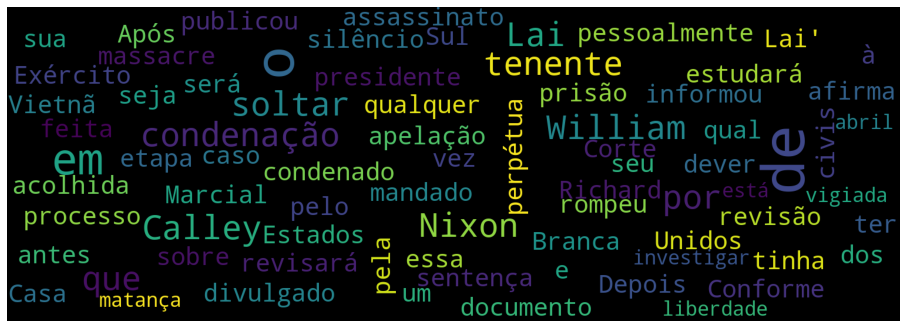

In [113]:
#Nuvem de Palavras texto 4.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [114]:
#puxando texto 5
texto5 = "1971: Ingleses propõem que Nobel da Paz seja entregue aos irmãos Villas Bôas': ' Os 28 anos de trabalhos dedicados aos índios poderão dar aos irmãos Orlando e Claudio Villas Bôas o Prêmio Nobel da Paz deste ano. A indicação dos nomes dos sertanistas brasileiros foi feita pela Fundação dos Povos Primitivos, com sede em Londres.Durante esses anos, os irmãos enfrentaram muitos perigos nas matas para tentar garantir aos índios o direito de evoluir naturalmente, mantendo a cultura, costumes e tradições. Orlando disse estar honrado com a indicação. “O que se pretende é prestigiar alguém que simbolize o movimento humanístico de assistência aos índios”, declarou. 14 de fevereiro de 1971"
doc5 = nlp(texto5)

In [115]:
#tokenização texto 5
tokens = [token for token in doc5]
[(token.orth_, token.pos_) for token in doc5]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Ingleses', 'PROPN'),
 ('propõem', 'VERB'),
 ('que', 'SCONJ'),
 ('Nobel', 'PROPN'),
 ('da', 'ADP'),
 ('Paz', 'PROPN'),
 ('seja', 'AUX'),
 ('entregue', 'VERB'),
 ('aos', 'ADP'),
 ('irmãos', 'NOUN'),
 ('Villas', 'PROPN'),
 ('Bôas', 'PROPN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('Os', 'DET'),
 ('28', 'NUM'),
 ('anos', 'NOUN'),
 ('de', 'ADP'),
 ('trabalhos', 'NOUN'),
 ('dedicados', 'VERB'),
 ('aos', 'ADP'),
 ('índios', 'NOUN'),
 ('poderão', 'VERB'),
 ('dar', 'VERB'),
 ('aos', 'ADP'),
 ('irmãos', 'NOUN'),
 ('Orlando', 'PROPN'),
 ('e', 'CCONJ'),
 ('Claudio', 'PROPN'),
 ('Villas', 'PROPN'),
 ('Bôas', 'PROPN'),
 ('o', 'DET'),
 ('Prêmio', 'PROPN'),
 ('Nobel', 'PROPN'),
 ('da', 'ADP'),
 ('Paz', 'PROPN'),
 ('deste', 'ADP'),
 ('ano', 'NOUN'),
 ('.', 'PUNCT'),
 ('A', 'DET'),
 ('indicação', 'NOUN'),
 ('dos', 'ADP'),
 ('nomes', 'NOUN'),
 ('dos', 'ADP'),
 ('sertanistas', 'NOUN'),
 ('brasileiros', 'ADJ'),
 ('foi', 'AUX'),
 ('feita', 'VERB'),
 ('pela'

In [116]:
#puxando verbos texto 5
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto5)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{propõem, pretende, enfrentaram, dar, disse, prestigiar, simbolize}


['propor',
 'entregar',
 'dedicar',
 'poder',
 'dar',
 'feito',
 'enfrentar',
 'tentar',
 'garantir',
 'evoluir',
 'manter',
 'dizer',
 'pretender',
 'prestigiar',
 'simbolizar',
 'declarar']

In [117]:
#indentificando as entidades do texto 5
for ent in doc5.ents:
    print(ent.text, ent.label_)

Ingleses LOC
Nobel da Paz MISC
Villas Bôas PER
Orlando PER
Claudio Villas Bôas PER
Prêmio Nobel da Paz MISC
Fundação dos Povos Primitivos ORG
Londres LOC
Orlando PER


In [118]:
with open("C:/Users/joice/Sprint03/textos/texto5.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

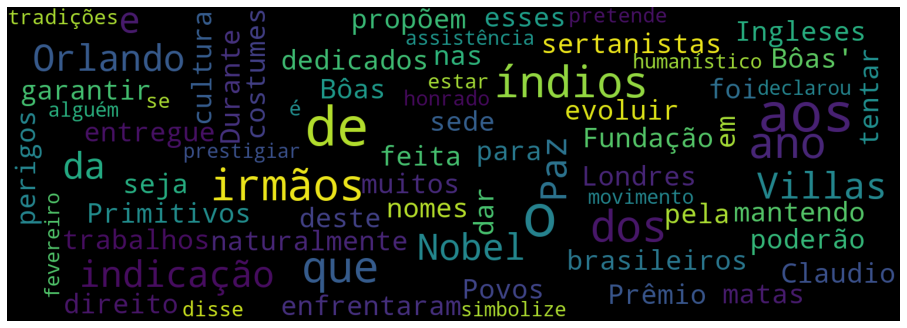

In [119]:
#Nuvem de Palavras texto 5.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [120]:
#puxando texto 6 
texto6 = "1971: Brasil lidera batalha para evitar que preço do café continue em queda': ' O Brasil abre nesta segunda-feira (8) a grande batalha para impedir que os preços do café no mercado internacional continuem a sofrer uma baixa desastrosa. Em Londres, o presidente do Instituto Brasileiro do Café, Mario Penteado de Faria e Silva, reunirá os principais produtores de café da América Latina para novamente procurar uma frente comum diante das exigências dos países consumidores, liderados pelos Estados Unidos. Para tentar estimular um nível melhor de preços, o Brasil pedirá que sejam reduzidas as cotas de exportação fixadas pelo Acordo Internacional do Café.  8 de fevereiro de 1971"
doc6 = nlp(texto6)

In [121]:
#tokenização texto 6
tokens = [token for token in doc6]
[(token.orth_, token.pos_) for token in doc6]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Brasil', 'PROPN'),
 ('lidera', 'VERB'),
 ('batalha', 'NOUN'),
 ('para', 'SCONJ'),
 ('evitar', 'VERB'),
 ('que', 'SCONJ'),
 ('preço', 'NOUN'),
 ('do', 'ADP'),
 ('café', 'NOUN'),
 ('continue', 'VERB'),
 ('em', 'ADP'),
 ('queda', 'NOUN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('O', 'DET'),
 ('Brasil', 'PROPN'),
 ('abre', 'VERB'),
 ('nesta', 'ADP'),
 ('segunda-feira', 'NOUN'),
 ('(', 'PUNCT'),
 ('8)', 'PUNCT'),
 ('a', 'DET'),
 ('grande', 'ADJ'),
 ('batalha', 'NOUN'),
 ('para', 'SCONJ'),
 ('impedir', 'VERB'),
 ('que', 'SCONJ'),
 ('os', 'DET'),
 ('preços', 'NOUN'),
 ('do', 'ADP'),
 ('café', 'NOUN'),
 ('no', 'ADP'),
 ('mercado', 'NOUN'),
 ('internacional', 'ADJ'),
 ('continuem', 'VERB'),
 ('a', 'SCONJ'),
 ('sofrer', 'VERB'),
 ('uma', 'DET'),
 ('baixa', 'NOUN'),
 ('desastrosa', 'ADJ'),
 ('.', 'PUNCT'),
 ('Em', 'ADP'),
 ('Londres', 'PROPN'),
 (',', 'PUNCT'),
 ('o', 'DET'),
 ('presidente', 'NOUN'),
 ('do', 'ADP'),
 ('Instituto', 'PROPN'),
 ('Br

In [122]:
#puxando verbos texto6
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto6)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{pedirá, sofrer, abre, lidera, continue, reunirá}


['liderar',
 'evitar',
 'continuar',
 'abrir',
 'impedir',
 'continuar',
 'sofrer',
 'reunir',
 'procurar',
 'liderar',
 'tentar',
 'estimular',
 'pedir',
 'reduzir',
 'fixar']

In [123]:
#indentificando as entidades do texto 6
for ent in doc6.ents:
    print(ent.text, ent.label_)

Brasil LOC
O Brasil MISC
Londres LOC
Instituto Brasileiro do Café LOC
Mario Penteado de Faria e Silva MISC
América Latina ORG
Estados Unidos LOC
Brasil LOC
Acordo Internacional do Café ORG


In [124]:
with open("C:/Users/joice/Sprint03/textos/texto6.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

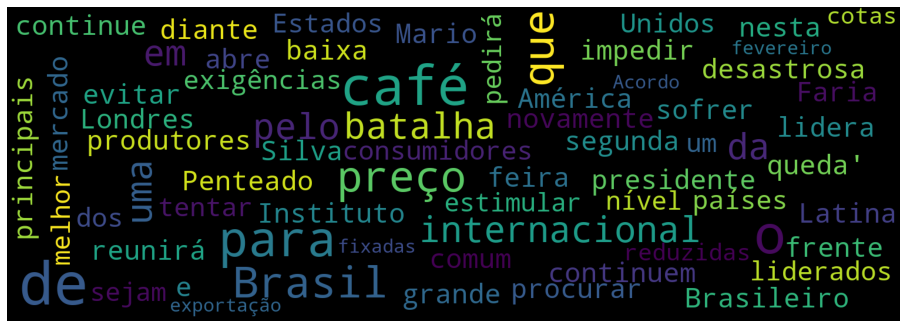

In [125]:
#Nuvem de Palavras texto 6.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [126]:
#puxando texto 7
texto7 = "1971: Campeonato Nacional de Futebol vai substituir o velho Robertão': ' A CBD (Confederação Brasileira de Desportos) aprovou nesta quarta-feira (4) as diretrizes para a realização do Campeonato Nacional de Futebol Profissional. Com isso, o Torneio Roberto Gomes Pedrosa, o Robertão, não será mais disputado. O Campeonato Nacional está previsto para começar a partir de agosto, com 20 clubes (dos estados de São Paulo, Guanabara, Minas Gerais, Rio Grande do Sul, Pernambuco, Bahia, Paraná e Ceará).Para estabelecer as bases da nova competição, a confederação considerou as cidades em que todas as partidas serão disputadas levando em conta os estádios. 5 de fevereiro de 1971"
doc7 = nlp(texto7)

In [127]:
#tokenização texto 7
tokens = [token for token in doc7]
[(token.orth_, token.pos_) for token in doc7]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Campeonato', 'PROPN'),
 ('Nacional', 'PROPN'),
 ('de', 'ADP'),
 ('Futebol', 'PROPN'),
 ('vai', 'AUX'),
 ('substituir', 'VERB'),
 ('o', 'DET'),
 ('velho', 'ADJ'),
 ('Robertão', 'PROPN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('A', 'DET'),
 ('CBD', 'PROPN'),
 ('(', 'PUNCT'),
 ('Confederação', 'PROPN'),
 ('Brasileira', 'PROPN'),
 ('de', 'ADP'),
 ('Desportos', 'PROPN'),
 (')', 'PUNCT'),
 ('aprovou', 'VERB'),
 ('nesta', 'ADP'),
 ('quarta-feira', 'NOUN'),
 ('(', 'PUNCT'),
 ('4', 'NUM'),
 (')', 'PUNCT'),
 ('as', 'DET'),
 ('diretrizes', 'NOUN'),
 ('para', 'ADP'),
 ('a', 'DET'),
 ('realização', 'NOUN'),
 ('do', 'ADP'),
 ('Campeonato', 'PROPN'),
 ('Nacional', 'PROPN'),
 ('de', 'ADP'),
 ('Futebol', 'PROPN'),
 ('Profissional', 'PROPN'),
 ('.', 'PUNCT'),
 ('Com', 'ADP'),
 ('isso', 'PRON'),
 (',', 'PUNCT'),
 ('o', 'DET'),
 ('Torneio', 'PROPN'),
 ('Roberto', 'PROPN'),
 ('Gomes', 'PROPN'),
 ('Pedrosa', 'PROPN'),
 (',', 'PUNCT'),
 ('o', 'DET'),
 ('Rob

In [128]:
#puxando verbos texto 7
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto7)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{considerou, disputado}


['substituir',
 'aprovar',
 'disputar',
 'começar',
 'Ceará).Para',
 'estabelecer',
 'considerar',
 'disputar',
 'levar']

In [129]:
#indentificando as entidades do texto 7
for ent in doc7.ents:
    print(ent.text, ent.label_)

Campeonato Nacional de Futebol MISC
Robertão MISC
A CBD MISC
Confederação Brasileira de Desportos ORG
Campeonato Nacional de Futebol Profissional MISC
Torneio Roberto Gomes Pedrosa MISC
Robertão MISC
Campeonato Nacional MISC
São Paulo LOC
Guanabara LOC
Minas Gerais LOC
Rio Grande do Sul LOC
Pernambuco LOC
Bahia LOC
Paraná LOC
Ceará).Para LOC


In [130]:
with open("C:/Users/joice/Sprint03/textos/texto7.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

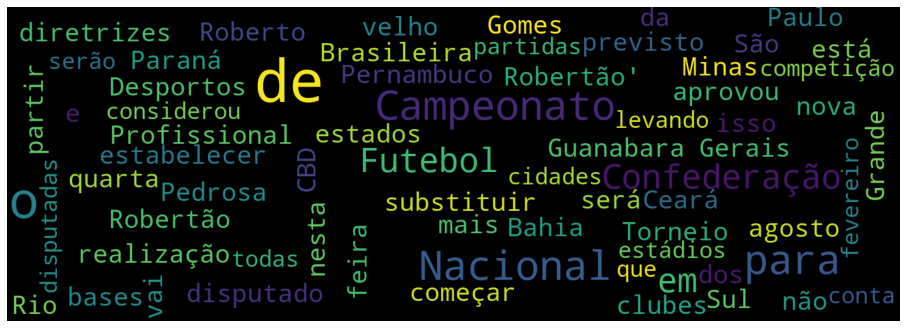

In [131]:
#Nuvem de Palavras texto 7.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [132]:
#puxando texto8
texto8 = "1971: Estudantes localizam o 1º foco de ferrugem do cafeeiro em São Paulo': ' Em uma fazenda em Pedregulho (a cerca de 480 quilômetros ao norte de São Paulo), dois estudantes de agronomia encontraram o primeiro foco da ferrugem do cafeeiro no estado.Uma comitiva de técnicos viajou para o local para realizar os trabalhos de interdição e de isolamento da área afetada pela doença que ataca os cafezais. A estratégia para impedir a propagação da ferrugem envolve toda a região da Alta Mogiana e vai exigir a vistoria em veículos para tentar impedir a transferência de qualquer muda, galho, folha ou fruto do café para outras áreas do estado. 30 janeiro de 1971"
doc8 = nlp(texto8)

In [133]:
#tokenização texto 8
tokens = [token for token in doc8]
[(token.orth_, token.pos_) for token in doc8]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Estudantes', 'NOUN'),
 ('localizam', 'VERB'),
 ('o', 'DET'),
 ('1º', 'ADJ'),
 ('foco', 'NOUN'),
 ('de', 'ADP'),
 ('ferrugem', 'NOUN'),
 ('do', 'ADP'),
 ('cafeeiro', 'NOUN'),
 ('em', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('Em', 'ADP'),
 ('uma', 'DET'),
 ('fazenda', 'NOUN'),
 ('em', 'ADP'),
 ('Pedregulho', 'PROPN'),
 ('(', 'PUNCT'),
 ('a', 'ADP'),
 ('cerca', 'ADV'),
 ('de', 'ADP'),
 ('480', 'NUM'),
 ('quilômetros', 'NOUN'),
 ('ao', 'ADP'),
 ('norte', 'NOUN'),
 ('de', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 (')', 'PUNCT'),
 (',', 'PUNCT'),
 ('dois', 'NUM'),
 ('estudantes', 'NOUN'),
 ('de', 'ADP'),
 ('agronomia', 'NOUN'),
 ('encontraram', 'VERB'),
 ('o', 'DET'),
 ('primeiro', 'ADJ'),
 ('foco', 'NOUN'),
 ('da', 'ADP'),
 ('ferrugem', 'NOUN'),
 ('do', 'ADP'),
 ('cafeeiro', 'NOUN'),
 ('no', 'ADP'),
 ('estado', 'NOUN'),
 ('.', 'PUNCT'),
 ('Uma', 'DET'),
 ('comitiva', 'NOUN'),
 ('de', 'AD

In [134]:
#puxando verbo texto 8
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto8)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{localizam, viajou, ataca, envolve, encontraram}


['localizar',
 'encontrar',
 'viajar',
 'realizar',
 'afetada',
 'atacar',
 'impedir',
 'envolver',
 'exigir',
 'tentar',
 'impedir']

In [135]:
#indentificando as entidades do texto 8
for ent in doc8.ents:
    print(ent.text, ent.label_)

São Paulo LOC
Pedregulho LOC
São Paulo LOC
Alta Mogiana LOC


In [136]:
with open("C:/Users/joice/Sprint03/textos/texto8.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

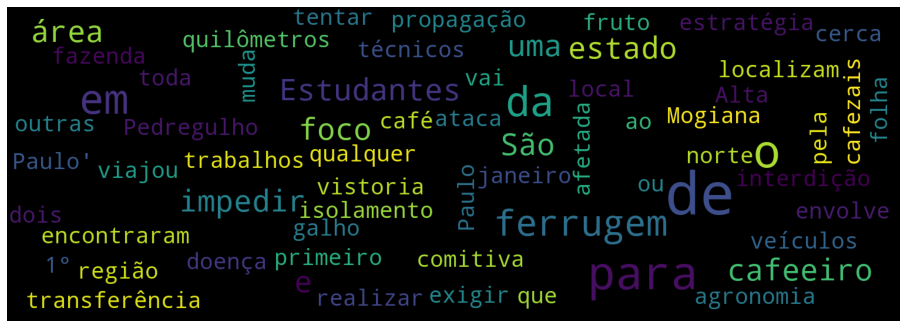

In [137]:
#Nuvem de Palavras texto 8.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [138]:
#puxando texto 9
texto9 = "1971: Se o sistema falhar, astronautas podem fazer 'passeio' pelo espaço: ' Os astronautas da Apollo 14 poderão passar do módulo lunar para a nave de comando caminhando pelo espaço, na hipótese de o sistema de acoplamento falhar no momento de iniciar a viagem de volta para a Terra. Essa alternativa foi aventada após o mecanismo ter apresentado dificuldade para fazer a junção na ida. O diretor do programa de voos espaciais, Jim McDivitt, diz que os astronautas dispõem de equipamento de socorro, com oxigênio, cordão umbilical e outros artefatos, o que possibilita um passeio espacial entre as naves. O pouso na Lua está previsto para ocorrer na sexta-feira (5). 3 de fevereiro de 1971"
doc9 = nlp(texto9)

In [139]:
#tokenização texto 9
tokens = [token for token in doc9]
[(token.orth_, token.pos_) for token in doc9]

[('1971', 'NUM'),
 (':', 'PUNCT'),
 ('Se', 'SCONJ'),
 ('o', 'DET'),
 ('sistema', 'NOUN'),
 ('falhar', 'VERB'),
 (',', 'PUNCT'),
 ('astronautas', 'NOUN'),
 ('podem', 'VERB'),
 ('fazer', 'VERB'),
 ("'", 'PUNCT'),
 ('passeio', 'NOUN'),
 ("'", 'PUNCT'),
 ('pelo', 'ADP'),
 ('espaço', 'NOUN'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('Os', 'DET'),
 ('astronautas', 'NOUN'),
 ('da', 'ADP'),
 ('Apollo', 'PROPN'),
 ('14', 'NUM'),
 ('poderão', 'VERB'),
 ('passar', 'VERB'),
 ('do', 'ADP'),
 ('módulo', 'NOUN'),
 ('lunar', 'ADJ'),
 ('para', 'ADP'),
 ('a', 'DET'),
 ('nave', 'NOUN'),
 ('de', 'ADP'),
 ('comando', 'NOUN'),
 ('caminhando', 'VERB'),
 ('pelo', 'ADP'),
 ('espaço', 'NOUN'),
 (',', 'PUNCT'),
 ('na', 'ADP'),
 ('hipótese', 'NOUN'),
 ('de', 'SCONJ'),
 ('o', 'DET'),
 ('sistema', 'NOUN'),
 ('de', 'ADP'),
 ('acoplamento', 'NOUN'),
 ('falhar', 'VERB'),
 ('no', 'ADP'),
 ('momento', 'NOUN'),
 ('de', 'SCONJ'),
 ('iniciar', 'VERB'),
 ('a', 'DET'),
 ('viagem', 'NOUN'),
 ('de', 'ADP'),
 ('volta', 'NOUN'),
 ('p

In [140]:
#puxando verbos texto 9
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto9)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']

{possibilita, falhar, falhar, dispõem, diz, passar, fazer}


['falhar',
 'poder',
 'fazer',
 'poder',
 'passar',
 'caminhar',
 'falhar',
 'iniciar',
 'aventar',
 'apresentar',
 'fazer',
 'dizer',
 'dispor',
 'possibilitar',
 'ocorrer']

In [141]:
#indentificando as entidades do texto 9
for ent in doc9.ents:
    print(ent.text, ent.label_)

Apollo 14 MISC
Terra LOC
Jim McDivitt PER
Lua LOC


In [142]:
with open("C:/Users/joice/Sprint03/textos/texto9.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

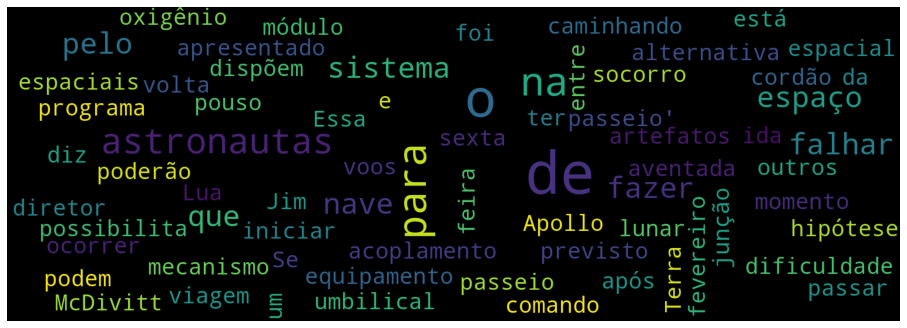

In [143]:
#Nuvem de Palavras texto 9.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [144]:
#puxando texto 10
texto10 = "1970: Fraude faz Faculdade da Santa Casa de São Paulo anular o vestibular': ' Com a descoberta da venda de provas e consequente quebra do sigilo das questões, a Faculdade de Ciências Médicas da Santa Casa de Misericórdia, em São Paulo, anulou os dois exames do vestibular, feitos na semana passada, e cancelou o último, que seria realizado no domingo (20). Um funcionário da faculdade confessou, no Deops (Departamento Estadual de Ordem Política e Social de São Paulo), a sua participação no caso. Estudantes suspeitos de terem oferecido dinheiro em troca das questões também estavam sendo interrogados.Estão inscritos no vestibular 2.800 candidatos para disputar 100 vagas. 21 de dezembro de 1970"
doc10 = nlp(texto10)

In [145]:
#tokenização texto 10
tokens = [token for token in doc10]
[(token.orth_, token.pos_) for token in doc10]

[('1970', 'NUM'),
 (':', 'PUNCT'),
 ('Fraude', 'PROPN'),
 ('faz', 'VERB'),
 ('Faculdade', 'PROPN'),
 ('da', 'ADP'),
 ('Santa', 'PROPN'),
 ('Casa', 'PROPN'),
 ('de', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 ('anular', 'VERB'),
 ('o', 'DET'),
 ('vestibular', 'NOUN'),
 ("'", 'PUNCT'),
 (':', 'PUNCT'),
 ("'", 'PUNCT'),
 ('Com', 'ADP'),
 ('a', 'DET'),
 ('descoberta', 'NOUN'),
 ('da', 'ADP'),
 ('venda', 'NOUN'),
 ('de', 'ADP'),
 ('provas', 'NOUN'),
 ('e', 'CCONJ'),
 ('consequente', 'ADJ'),
 ('quebra', 'NOUN'),
 ('do', 'ADP'),
 ('sigilo', 'NOUN'),
 ('das', 'ADP'),
 ('questões', 'NOUN'),
 (',', 'PUNCT'),
 ('a', 'DET'),
 ('Faculdade', 'PROPN'),
 ('de', 'ADP'),
 ('Ciências', 'PROPN'),
 ('Médicas', 'PROPN'),
 ('da', 'ADP'),
 ('Santa', 'PROPN'),
 ('Casa', 'PROPN'),
 ('de', 'ADP'),
 ('Misericórdia', 'PROPN'),
 (',', 'PUNCT'),
 ('em', 'ADP'),
 ('São', 'PROPN'),
 ('Paulo', 'PROPN'),
 (',', 'PUNCT'),
 ('anulou', 'VERB'),
 ('os', 'DET'),
 ('dois', 'NUM'),
 ('exames', 'NOUN'),
 ('do', 'ADP'),
 (

In [146]:
#puxando verbos texto 10
nlp = spacy.load("pt_core_news_sm")
doc = nlp(texto10)
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)
[token.lemma_ for token in doc if token.pos_ == 'VERB']


{faz, confessou, anulou}


['fazer',
 'anular',
 'anular',
 'feito',
 'cancelar',
 'realizar',
 'confessar',
 'oferecer',
 'interrogar',
 'disputar']

In [147]:
#indentificando as entidades do texto 10
for ent in doc10.ents:
    print(ent.text, ent.label_)

Fraude LOC
Faculdade da Santa Casa de São Paulo LOC
Faculdade de Ciências Médicas da Santa Casa de Misericórdia ORG
São Paulo LOC
Deops LOC
Departamento Estadual de Ordem Política LOC
Social de São Paulo LOC


In [148]:
with open("C:/Users/joice/Sprint03/textos/texto10.txt", "r", encoding='utf-8') as f:
    artigos = f.read()

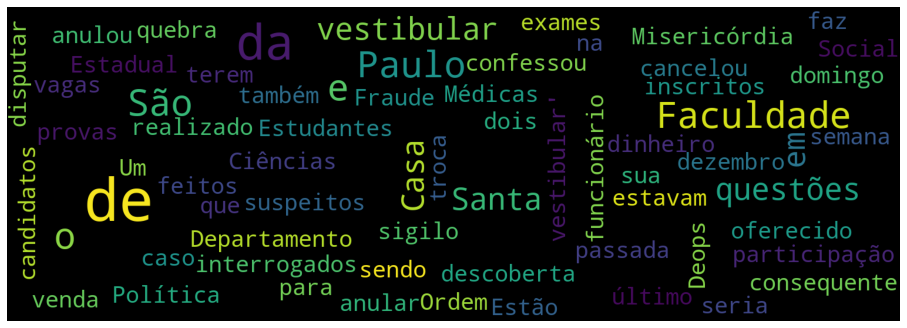

In [149]:
#Nuvem de Palavras texto 10.
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(artigos)
stopwords = set(STOPWORDS)
stopwords.add("said")

plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [150]:
#treinamento dataset tweets
dataset = pd.read_csv('C:/Users/joice/Sprint03/textos/Tweets_Mg.csv',encoding='utf-8')
dataset.count()

Unnamed: 0                   8199
Created At                   8199
Text                         8199
Geo Coordinates.latitude      104
Geo Coordinates.longitude     104
User Location                5489
Username                     8199
User Screen Name             8199
Retweet Count                8199
Classificacao                8199
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [151]:
#classificacao positivo
dataset[dataset.Classificacao == 'Positivo'].count()

Unnamed: 0                   3300
Created At                   3300
Text                         3300
Geo Coordinates.latitude        1
Geo Coordinates.longitude       1
User Location                2118
Username                     3300
User Screen Name             3300
Retweet Count                3300
Classificacao                3300
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [152]:
#classificacao negativo
dataset[dataset.Classificacao == 'Negativo'].count()

Unnamed: 0                   2446
Created At                   2446
Text                         2446
Geo Coordinates.latitude        1
Geo Coordinates.longitude       1
User Location                1659
Username                     2446
User Screen Name             2446
Retweet Count                2446
Classificacao                2446
Observação                      0
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

In [153]:
#mostrando o dataset
dataset.head()

Unnamed: 0                      Created At  \
0           0  Sun Jan 08 01:22:05 +0000 2017   
1           1  Sun Jan 08 01:49:01 +0000 2017   
2           2  Sun Jan 08 01:01:46 +0000 2017   
3           3  Wed Jan 04 21:43:51 +0000 2017   
4           4  Mon Jan 09 15:08:21 +0000 2017   

                                                                                                                             Text  \
0                                              ���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ   
1                                                                  � @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf   
2                                                                 �� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw   
3                                                                                                     ��� https://t.co/BnDsO34qK0   
4  ��� PSOL vai questionar aumento de vereadores e prefeito de BH na Justiça - Politica - Estado de Minas https://t.co/DMg7BGsek5   

   Geo Coordinates.latitude  Geo Coordinates.longitude User Location  \
0                       NaN                        NaN        Brasil   
1                  -41.9333                     -18.85           NaN   
2                  -41.9333                     -18.85           NaN   
3                       NaN                        NaN           NaN   
4                       NaN                        NaN           NaN   

               Username User Screen Name  Retweet Count Classificacao  \
0  Leonardo C Schneider    LeoCSchneider              0        Neutro   
1               Wândell         klefnews              0        Neutro   
2               Wândell         klefnews              0        Neutro   
3         Ana estudando  estudandoconcur              0        Neutro   
4                 Emily         Milly777              0      Negativo   

  Observação  Unnamed: 10  Unnamed: 11  Unnamed: 12  Unnamed: 13  Unnamed: 14  \
0        NaN          NaN          NaN          NaN          NaN          NaN   
1        NaN          NaN          NaN          NaN          NaN          NaN   
2        NaN          NaN          NaN          NaN          NaN          NaN   
3        NaN          NaN          NaN          NaN          NaN          NaN   
4        NaN          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 15  Unnamed: 16  Unnamed: 17  Unnamed: 18  Unnamed: 19  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 20  Unnamed: 21  Unnamed: 22  Unnamed: 23  Unnamed: 24  
0          NaN          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN          NaN

In [154]:
#analise dos tweets
tweets = dataset["Text"].values
tweets

array(['���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ',
       '� @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf',
       '�� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw',
       ...,
       'Trio é preso suspeito de roubo, tráfico e abuso sexual em Uberlândia https://t.co/zaQbXRRJWc',
       'Trio é preso suspeito de roubo, tráfico e abuso sexual em Uberlândia: Um dos autores teria molestado vítima de… https://t.co/lQ8cTSNftA',
       'Trio suspeito de roubo de cargas é preso em Santa Luzia (MG) https://t.co/0INgJcMtZb #R7MG #RecordTVMinas'],
      dtype=object)

In [155]:
#mostrando a array de classificação
classes = dataset["Classificacao"].values
classes

array(['Neutro', 'Neutro', 'Neutro', ..., 'Positivo', 'Positivo',
       'Positivo'], dtype=object)

In [156]:
#vetorizando 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
tokens = [token for token in doc]
[(token.orth_, token.pos_) for token in doc]

Vectorizer = CountVectorizer(analyzer = "word")
freq_tweets = Vectorizer.fit_transform(tweets)

modelo = MultinomialNB()
modelo.fit(freq_tweets, classes)

MultinomialNB()

In [157]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv = 10)
resultados

array(['Neutro', 'Neutro', 'Neutro', ..., 'Positivo', 'Positivo',
       'Positivo'], dtype='<U8')

In [158]:
import sklearn.metrics as metrics

metrics.accuracy_score(classes, resultados)

0.8831564824978656

In [164]:
sentimentos = ["Positivo", "Negativo", "Neutro"]
print(metrics.classification_report(classes, resultados, sentimentos))

              precision    recall  f1-score   support

    Positivo       0.95      0.88      0.91      3300
    Negativo       0.89      0.93      0.91      2446
      Neutro       0.80      0.84      0.82      2453

    accuracy                           0.88      8199
   macro avg       0.88      0.88      0.88      8199
weighted avg       0.89      0.88      0.88      8199

C:\Users\joice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['Positivo', 'Negativo', 'Neutro'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [165]:
#testes com os titulos dos textos:
# 1971: Dom Paulo Evaristo Arns sofre acidente automobilístico em SC
# 1971: Chuvas provocam 22 mortes em São Paulo, no ABC e na Baixada Santista
# 1971: Petrobras intensifica pesquisas no mar e contrata 2 navios-sonda
# 1971: Após soltar tenente, Nixon estudará condenação por massacre de My Lai
# 1971: Ingleses propõem que Nobel da Paz seja entregue aos irmãos Villas Bôas
# 1971: Brasil lidera batalha para evitar que preço do café continue em queda
# 1971: Campeonato Nacional de Futebol vai substituir o velho Robertão
# 1971: Estudantes localizam o 1º foco de ferrugem do cafeeiro em São Paulo
# 1971: Se o sistema falhar, astronautas podem fazer 'passeio' pelo espaço
# 1970: Fraude faz Faculdade da Santa Casa de São Paulo anular o vestibular

In [166]:
#teste com os paragrafos dos textos!!
testes = ["Dom Paulo Evaristo Arns sofre acidente automobilístico em SC", "Chuvas provocam 22 mortes em São Paulo, no ABC e na Baixada Santista","Petrobras intensifica pesquisas no mar e contrata 2 navios-sonda","Após soltar tenente, Nixon estudará condenação por massacre de My Lai", "Ingleses propõem que Nobel da Paz seja entregue aos irmãos Villas Bôas","Brasil lidera batalha para evitar que preço do café continue em queda", "Campeonato Nacional de Futebol vai substituir o velho Robertão", "Estudantes localizam o 1º foco de ferrugem do cafeeiro em São Paulo", "Se o sistema falhar, astronautas podem fazer 'passeio' pelo espaço","Fraude faz Faculdade da Santa Casa de São Paulo anular o vestibular"]        
freq_testes = Vectorizer.transform(testes)
sentimento = modelo.predict(freq_testes)

In [161]:
print(sentimento)

['Neutro' 'Positivo' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Negativo' 'Neutro' 'Positivo']


In [162]:
#criando dataframe com os titulos e a classificacao
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)


df_sentimento = pd.DataFrame(sentimento, testes)
df_sentimento = df_sentimento.rename(columns={0: 'Títulos --> classificacao'})
print(df_sentimento)

                                                                       Títulos --> classificacao
Dom Paulo Evaristo Arns sofre acidente automobilístico em SC                              Neutro
Chuvas provocam 22 mortes em São Paulo, no ABC e na Baixada Santista                    Positivo
Petrobras intensifica pesquisas no mar e contrata 2 navios-sonda                          Neutro
Após soltar tenente, Nixon estudará condenação por massacre de My Lai                     Neutro
Ingleses propõem que Nobel da Paz seja entregue aos irmãos Villas Bôas                    Neutro
Brasil lidera batalha para evitar que preço do café continue em queda                     Neutro
Campeonato Nacional de Futebol vai substituir o velho Robertão                            Neutro
Estudantes localizam o 1º foco de ferrugem do cafeeiro em São Paulo                     Negativo
Se o sistema falhar, astronautas podem fazer 'passeio' pelo espaço                        Neutro
Fraude faz Faculdade da Santa 

In [163]:
# salvando o treinamento no mongo
cliente = pymongo.MongoClient("mongodb://localhost:27017/")
banco = cliente['Tratamento'] 
gravando = banco["Sentimentos"]
dados = df_sentimento.to_dict('list')
valor = ((dados))
gravando_banco = gravando.insert_one(valor)